In [1]:
#import the neccesary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import skimage
import skimage.transform
import os
import re
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as ssim
import math
from tensorflow.keras.applications.vgg16 import VGG16
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
#create the training set 
import skimage.transform
def CreateSet(input_list,N_patches,patchsize):
    """
    Creates an array that can be used as input and output for the model
    parameters: input_list, a list with indices of the images that are used
                N_patches, the amount of image patches the model creates per image
                patchsize, the width and height of the square image patch
    
    """
    X = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 1), dtype=np.float32)
    y = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 3), dtype=np.float32)
    for j in range(N_patches):
        for n,i in enumerate(input_list):
            #random pixel location
            ii = j*len(input_list)+n
            xloc = random.randint(0,401-patchsize)
            yloc = random.randint(0,801-patchsize)
            #input 
            img_input = Image.open('bandLimited/input_%03d.png' % (i+1))
            in_img_input = tf.keras.preprocessing.image.img_to_array(img_input)
            in_img_input = in_img_input[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_input = skimage.transform.resize(in_img_input , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            X[ii] = in_img_input / 255.0
            #output
            img_output = Image.open('groundTruth/target_%03d.png' % (i+1))
            in_img_output = tf.keras.preprocessing.image.img_to_array(img_output)
            in_img_output = in_img_output[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_output = skimage.transform.resize(in_img_output , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            in_img_output = np.concatenate((in_img_output,in_img_output,in_img_output),axis=-1)
            y[ii] = in_img_output / 255.0
            if ii % 1000 == 0:
                print(ii)
    print('Done')
    return X,y
#amount of patches per image
N_patches = 64
#width and height of the patches
patchsize = 128
#Train set is image 1 till 400
X_train,y_train = CreateSet(range(401),N_patches,patchsize)
#validation set is image 402 till 535
X_valid,y_valid = CreateSet(range(401,535),N_patches,patchsize)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
Done
0
1000
2000
3000
4000
5000
6000
7000
8000
Done


In [3]:
#Create the arrays for the Test set which are the image 601 till 669
test_set_indices = range(535,669)

Test_set_X = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
Test_set_y = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
for i,n in enumerate(test_set_indices):
    img = Image.open('bandLimited/input_%03d.png' % (n+1))
    in_img_input = tf.keras.preprocessing.image.img_to_array(img)
    in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
    Test_set_X[i] =in_img_input / 255.0

    img = Image.open('groundTruth/target_%03d.png' % (n+1))
    in_img_output = tf.keras.preprocessing.image.img_to_array(img)
    in_img_output = skimage.transform.resize(in_img_output , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
    Test_set_y[i] =in_img_output / 255.0

In [2]:
def Conv2D_Block(input_tensor , n_filters):
    """
    A function that defines a block of two conv2D layers
    Parameter: input_tensor: the model/input tensor to which these layers are added
    returns: x: the model with the two conv2D layer
    """
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

def U_Net(img_tensor , n_filters = 16):
    """
    Creates the U_net model
    returns: u_net, the u_net model
    """
    #512X512
    conv1 = Conv2D_Block(img_tensor , n_filters * 1)
    pool1 = tf.keras.layers.MaxPooling2D((2 , 2))(conv1)
    pool1 = tf.keras.layers.Dropout(0.05)(pool1)
    #256x256
    conv2 = Conv2D_Block(pool1 , n_filters * 2)
    pool2 = tf.keras.layers.MaxPooling2D((2 , 2))(conv2)
    pool2 = tf.keras.layers.Dropout(0.05)(pool2)
    #128x128
    conv3 = Conv2D_Block(pool2 , n_filters * 4)
    pool3 = tf.keras.layers.MaxPooling2D((2 , 2))(conv3)
    pool3 = tf.keras.layers.Dropout(0.05)(pool3)
    #64x64
    conv4 = Conv2D_Block(pool3 , n_filters * 8)
    pool4 = tf.keras.layers.MaxPooling2D((2 , 2))(conv4)
    pool4 = tf.keras.layers.Dropout(0.05)(pool4)
    #32x32
    conv5 = Conv2D_Block(pool4 , n_filters * 16)
    #32x32
    pool6 = tf.keras.layers.Conv2DTranspose(n_filters * 8 , (3 , 3) , (2, 2) , padding = 'same')(conv5)
    pool6 = tf.keras.layers.concatenate([pool6 , conv4])
    pool6 = tf.keras.layers.Dropout(0.05)(pool6)
    conv6 = Conv2D_Block(pool6 , n_filters * 8)
    #64x64
    pool7 = tf.keras.layers.Conv2DTranspose(n_filters * 4 , (3 , 3) , (2 , 2) , padding = 'same')(conv6)
    pool7 = tf.keras.layers.concatenate([pool7 , conv3])
    pool7 = tf.keras.layers.Dropout(0.05)(pool7)
    conv7 = Conv2D_Block(pool7 , n_filters * 4)
    #128x128
    pool8 = tf.keras.layers.Conv2DTranspose(n_filters * 2 , (3 , 3) , (2 , 2) , padding = 'same')(conv7)
    pool8 = tf.keras.layers.concatenate([pool8 , conv2])
    pool8 = tf.keras.layers.Dropout(0.05)(pool8)
    conv8 = Conv2D_Block(pool8 , n_filters * 2)
    #256x256
    pool9 = tf.keras.layers.Conv2DTranspose(n_filters * 1 , (3 , 3) , (2 , 2) , padding = 'same')(conv8)
    pool9 = tf.keras.layers.concatenate([pool9 , conv1])
    pool9 = tf.keras.layers.Dropout(0.05)(pool9)
    conv9 = Conv2D_Block(pool9 , n_filters * 1)
    #512x512
    #use relu for the activation
    output = tf.keras.layers.Conv2D(3 , (3 , 3), padding = 'same')(conv9)

    u_net = tf.keras.Model(inputs = [img_tensor] , outputs = [output])

    return u_net

In [3]:
image_shape = (None,None, 3)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_shape)
selectedLayers = ['block1_conv2','block2_conv2','block3_conv3','block4_conv3']
selectedOutputs = [vgg.get_layer(i).output for i in selectedLayers]
loss_model = tf.keras.Model(inputs=vgg.input, outputs=selectedOutputs)
loss_model.trainable = False
def perceptual_loss(y_true, y_pred):
    mse = 0
    for i in range(0,3):
        mse = (mse+ K.mean(K.square(loss_model(y_true)[i] - loss_model(y_pred)[i])))
    return mse

loss = [perceptual_loss, tf.keras.losses.MeanSquaredError]
loss_weights = [70,30]

In [4]:
#define and compile the model
img_tensor = tf.keras.layers.Input((None , None , 1) , name = 'img')
model = U_Net(img_tensor,16)

In [5]:

model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4),
            loss = loss,
            loss_weights = loss_weights,
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 1 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 1 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [6]:
model_path = 'model_model1unet_Ultrasound_data.h5'
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True, save_weights_only=True)
]

In [10]:
#train the model
results = model.fit(X_train,y_train, epochs=100, callbacks=callbacks,batch_size = 16,
                    validation_data=(X_valid,y_valid),shuffle=False)

Epoch 1/100
1604/1604 [==============================] - ETA: 0s - loss: 2949.8735 - root_mean_squared_error: 0.5033
Epoch 00001: val_loss improved from inf to 2092.94897, saving model to model_model1unet_Ultrasound_data.h5
1604/1604 [==============================] - 128s 80ms/step - loss: 2949.8735 - root_mean_squared_error: 0.5033 - val_loss: 2092.9490 - val_root_mean_squared_error: 0.6001 - lr: 1.0000e-04
Epoch 2/100
1604/1604 [==============================] - ETA: 0s - loss: 2041.7826 - root_mean_squared_error: 0.3257
Epoch 00002: val_loss improved from 2092.94897 to 1997.54565, saving model to model_model1unet_Ultrasound_data.h5
1604/1604 [==============================] - 130s 81ms/step - loss: 2041.7826 - root_mean_squared_error: 0.3257 - val_loss: 1997.5457 - val_root_mean_squared_error: 0.4752 - lr: 1.0000e-04
Epoch 3/100
1604/1604 [==============================] - ETA: 0s - loss: 1960.2273 - root_mean_squared_error: 0.3088
Epoch 00003: val_loss improved from 1997.54565 to 

Epoch 21/100
1604/1604 [==============================] - ETA: 0s - loss: 1755.0614 - root_mean_squared_error: 0.2381
Epoch 00021: val_loss improved from 1804.18628 to 1803.68835, saving model to model_model1unet_Ultrasound_data.h5
1604/1604 [==============================] - 127s 79ms/step - loss: 1755.0614 - root_mean_squared_error: 0.2381 - val_loss: 1803.6884 - val_root_mean_squared_error: 0.3853 - lr: 1.0000e-04
Epoch 22/100
1604/1604 [==============================] - ETA: 0s - loss: 1752.0190 - root_mean_squared_error: 0.2355
Epoch 00022: val_loss improved from 1803.68835 to 1803.45447, saving model to model_model1unet_Ultrasound_data.h5
1604/1604 [==============================] - 127s 79ms/step - loss: 1752.0190 - root_mean_squared_error: 0.2355 - val_loss: 1803.4545 - val_root_mean_squared_error: 0.3965 - lr: 1.0000e-04
Epoch 23/100
1604/1604 [==============================] - ETA: 0s - loss: 1749.1040 - root_mean_squared_error: 0.2338
Epoch 00023: val_loss improved from 1803

In [7]:
#load the model
model.load_weights(model_path)

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])


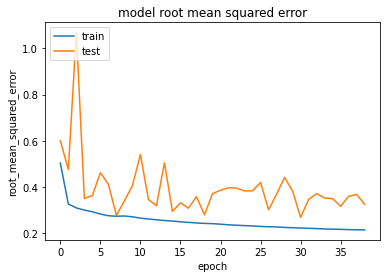

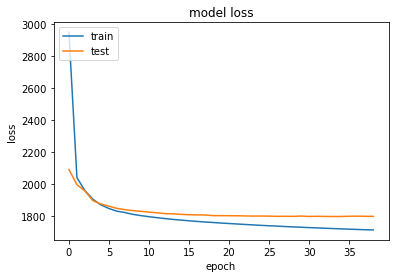

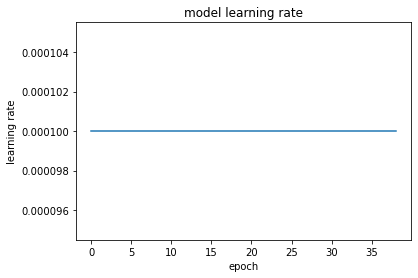

In [16]:
#visualise the accuracy and losses of the model
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['root_mean_squared_error'])
plt.plot(results.history['val_root_mean_squared_error'])
plt.title('model root mean squared error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(results.history['lr'])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()

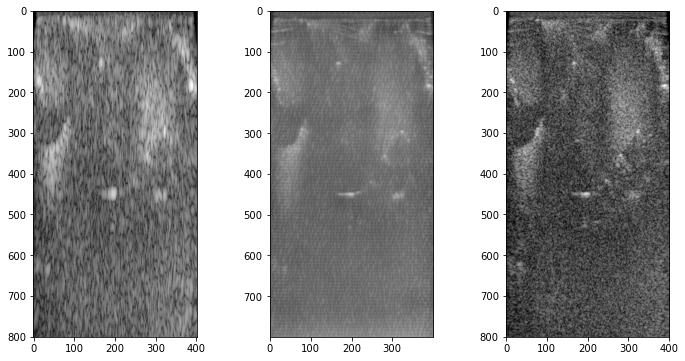

In [27]:
n =16
prediction = model.predict(np.expand_dims(Test_set_X[n,:800,:400] , 0))

prediction_image = prediction.squeeze()

fig,ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(Test_set_X[n].squeeze(),cmap = 'gray')
ax[1].imshow(prediction_image[:800,:400,0],cmap='gray')
ax[2].imshow(Test_set_y[n].squeeze(),cmap='gray')
plt.show()

In [11]:
def CreateTestSet(test_set_indices,input_dir_test,output_dir_test):
    """
    Function that reads in the test set images as arrays and scales them between 0 and 1
    parameters:test_set_indices: The indices of the the images in the test set
                 input_dir_test: The directory where the input png images are stored
                output_dir_test: The directory where the output png images are stored
    returns: Test_set_X: an array of input images
             Test_set_y: an array of output images
    """
    Test_set_X = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    Test_set_y = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    for i,n in enumerate(test_set_indices):
        img = Image.open(input_dir_test+'/input_%03d.png' % (n+1))
        in_img_input = tf.keras.preprocessing.image.img_to_array(img)
        in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_X[i] =in_img_input / 255.0

        img = Image.open(output_dir_test+'/target_%03d.png' % (n+1))
        in_img_output = tf.keras.preprocessing.image.img_to_array(img)
        in_img_output = skimage.transform.resize(in_img_output , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_y[i] =in_img_output / 255.0    
    print('Done')
    return Test_set_X, Test_set_y
#Run for all the datasets
for dataset in ['','CIRS_','carotid_']:
    if dataset == '':
        test_set_indices = range(535,669)
        input_dir_test = 'bandLimited'
        output_dir_test = 'groundTruth'
    if dataset == 'CIRS_':
        test_set_indices = range(11)
        input_dir_test = 'CIRSBandLimited'
        output_dir_test = 'CIRSGroundTruth'
    if dataset =='carotid_':
        test_set_indices = range(70)
        input_dir_test = 'carotidBandLimited'
        output_dir_test = 'carotidGroundTruth'
    #Create the input and output test set arrays
    Test_set_X, Test_set_y = CreateTestSet(test_set_indices,input_dir_test,output_dir_test)
    #Create an array with all the model predicted images
    prediction_images = np.zeros((len(Test_set_X),800,400),dtype=np.float32)
    for i in range(len(Test_set_X)):
        prediction_image = model.predict(np.expand_dims(Test_set_X[i,:800,:400] , 0))
        prediction_image = prediction_image[:,:,:,0]
        prediction_images[i] = prediction_image.squeeze()
    #save the array in a npy file
    np.save('Model_output_test_'+dataset+'unetmodel1_ultrasound.npy',prediction_images)

Done
Done
Done


In [8]:
#Create an array with all the train and validation input images
Train_set_indices = range(535)
Train_set_X = np.zeros((len(Train_set_indices), 801, 401,1), dtype=np.float32)
for i in Train_set_indices:
    img = Image.open('bandLimited/input_%03d.png' % (i+1))
    in_img_input = tf.keras.preprocessing.image.img_to_array(img)
    in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
    Train_set_X[i] =in_img_input / 255.0

In [9]:
#generate the model prediction for each image and save it as a png
prediction_images = np.zeros((len(Train_set_X),800,400),dtype=np.float32)
for i in Train_set_indices:
    prediction_image = model.predict(np.expand_dims(Train_set_X[i,:800,:400] , 0))
    prediction_image = prediction_image[:,:,:,0]
    #scale between 0 and 255
    prediction_image = prediction_image.squeeze()*255.0
    prediction_image  = Image.fromarray(prediction_image)
    if prediction_image.mode == "F":
        prediction_image = prediction_image.convert('RGB')
    #save the image
    prediction_image.save('bandLimited_unetmodel1/input_%03d.png' % (i+1))
    